# Time Series 02

In [5]:
# Preface
rm(list=ls())
library(dynlm)
library(forecast)
library(tseries)

In [6]:
# load data and assign Time Series structure
cpi=read.csv("cpi.csv")
y = cpi[,2]
y = ts(y,start=c(1947,1),freq=4)     # defining as TS
par(mfrow=c(2,2))
# calculating yearly inflation and account for structural break
z = 400*diff(log(y))
z2 = window(z,c(1984,1),c(2019,1))

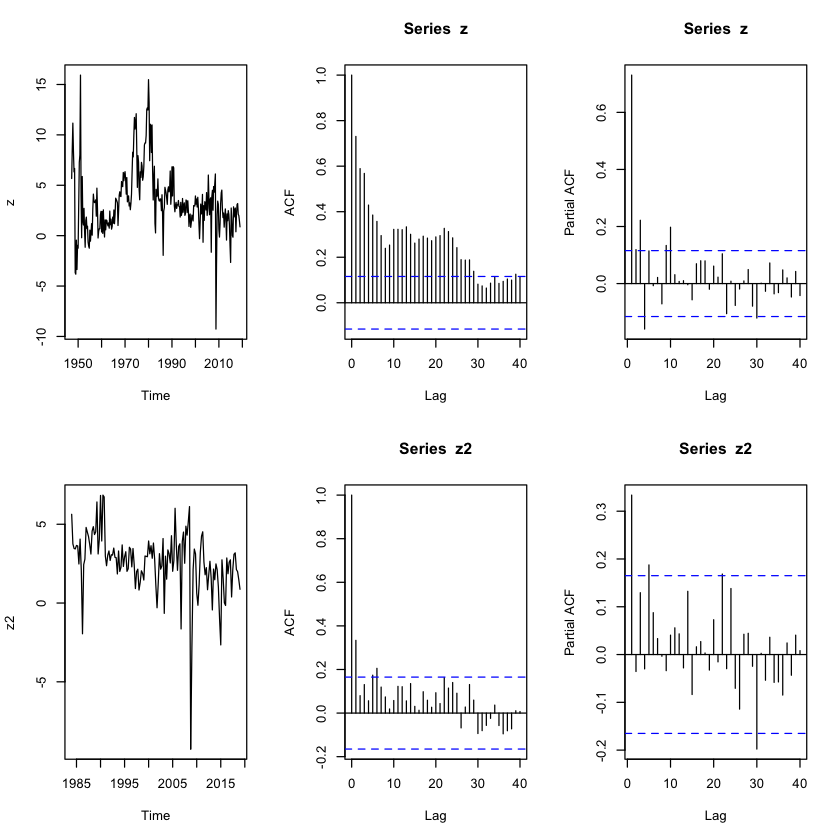

In [7]:
# Plot: TS, ACT, Partial ACF
par(mfrow=c(2,3))
ts.plot(z)
plot(Acf(z,lag.max=40,plot=F))
plot(Pacf(z,lag.max=40,plot=F))
ts.plot(z2)
plot(Acf(z2,lag.max=40,plot=F))
plot(Pacf(z2,lag.max=40,plot=F))

In [8]:
# test: non-zero autocorrelation at lags 4,8,12 (Ljung-Box)
Box.test(z2,lag = 4, type = 'Ljung-Box')   # p-value is 0.0005 hence we reject
Box.test(z2,lag = 8, type = 'Ljung-Box')
Box.test(z2,lag = 12, type = 'Ljung-Box')


	Box-Ljung test

data:  z2
X-squared = 19.92, df = 4, p-value = 0.0005178



	Box-Ljung test

data:  z2
X-squared = 33.659, df = 8, p-value = 4.683e-05



	Box-Ljung test

data:  z2
X-squared = 38.838, df = 12, p-value = 0.0001119



Time series regression with "ts" data:
Start = 1948(3), End = 2019(1)

Call:
dynlm(formula = z ~ L(z, c(1:5)))

Residuals:
     Min       1Q   Median       3Q      Max 
-14.1754  -0.9470   0.1037   1.0410   9.2990 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.61207    0.20082   3.048  0.00253 ** 
L(z, c(1:5))1  0.65265    0.05969  10.935  < 2e-16 ***
L(z, c(1:5))2 -0.05410    0.07009  -0.772  0.44084    
L(z, c(1:5))3  0.32963    0.06698   4.921 1.48e-06 ***
L(z, c(1:5))4 -0.22882    0.06972  -3.282  0.00116 ** 
L(z, c(1:5))5  0.10955    0.05902   1.856  0.06446 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.073 on 277 degrees of freedom
Multiple R-squared:  0.5763,	Adjusted R-squared:  0.5686 
F-statistic: 75.35 on 5 and 277 DF,  p-value: < 2.2e-16



	Box-Ljung test

data:  res5
X-squared = 0.058447, df = 4, p-value = 0.9996



	Box-Ljung test

data:  res5
X-squared = 6.4313, df = 8, p-value = 0.599



	Box-Ljung test

data:  res5
X-squared = 13.635, df = 12, p-value = 0.3246


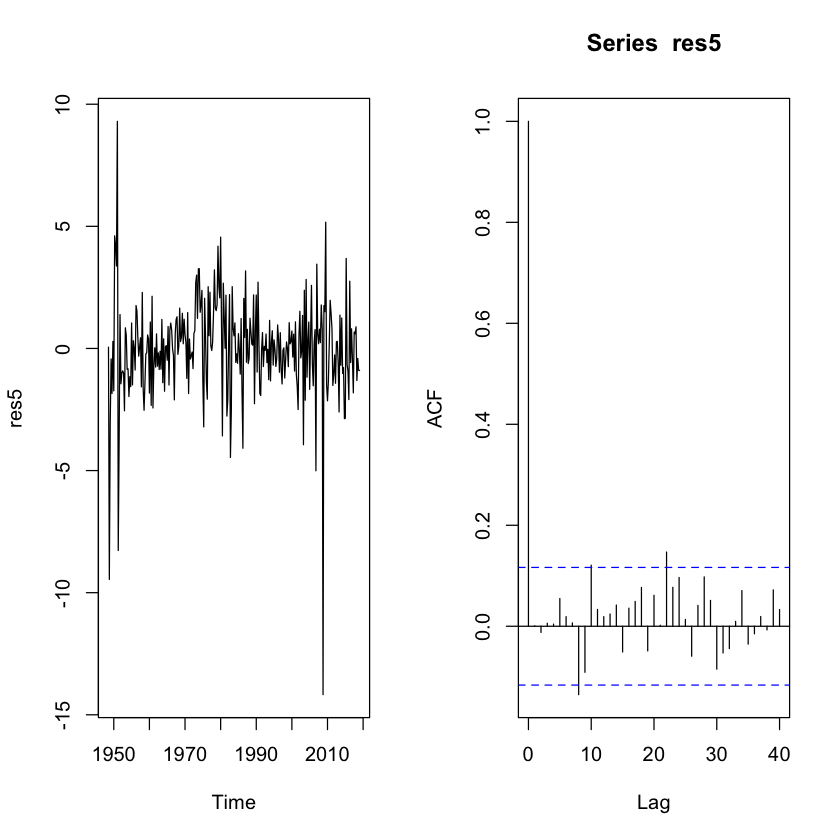

In [9]:
### How to set/ choose AR model?
#   Solution: by using information criteria e.g. AIC, BIC ...
#   Note: BIC is more restrictive when it comes to adding lags

# Check all AR(q)-models up to 5 lags - AIC determines optimal lag length
ar5.mod = dynlm(z ~ L(z,c(1:5)))
ar5 = summary(ar5.mod)
ar5  # here we just compute the AIC and BIC for an AR(5) by hand
aic5 = log(ar5$sigma^2) + 2*length(ar5$coef[,1])/length(z2)
bic5 = log(ar5$sigma^2) + log(length(z2))*length(ar5$coef[,1])/length(z2)
res5 = ar5$residuals
par(mfrow=c(1,2))
plot(res5)
plot(Acf(res5,lag.max=40,plot=F))
Box.test(res5,lag = 4, type = 'Ljung-Box')
Box.test(res5,lag = 8, type = 'Ljung-Box')
Box.test(res5,lag = 12, type = 'Ljung-Box')

In [10]:
### Constructing a Forecast for US-CPI in 2019Q2
#   using a simple AR(1)

ar1.mod = dynlm(z2 ~ L(z2,c(1:5)))
ar1 = summary(ar1.mod)
T = length(z2)
forec = ar1$coef[1,1] + ar1$coef[2,1]*z2[T]
forec
# assessing the uncertainty of the point forecast by 95%-CI
forec.upp = forec + 1.96*ar1$sigma
forec.low = forec - 1.96*ar1$sigma
round(c(forec.low,forec,forec.upp),3) # hence, our forecast is very unprecise!

[1] 1.595387

[1] -2.006  1.595  5.197


	Jarque Bera Test

data:  ar1$res
X-squared = 11.754, df = 2, p-value = 0.002803


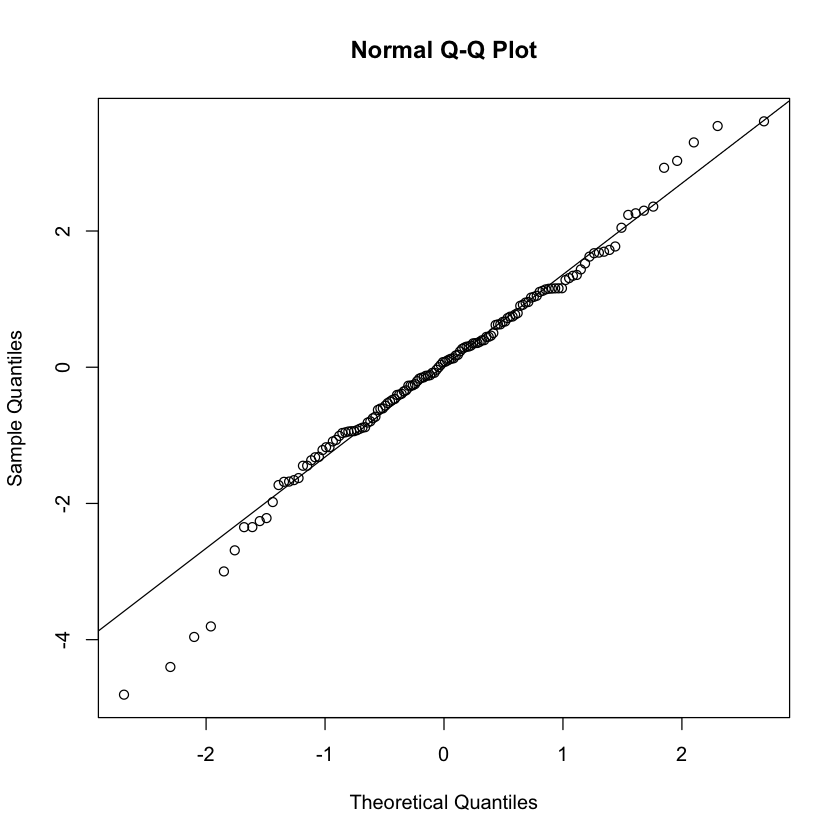

In [12]:
### Inspect residuals under normality
jarque.bera.test(ar1$res)
qqnorm(ar1$res)
qqline(ar1$res)
# we see that the obs. in the left corner is likely driving our results
# let's create a recession dummy for 2008Q4

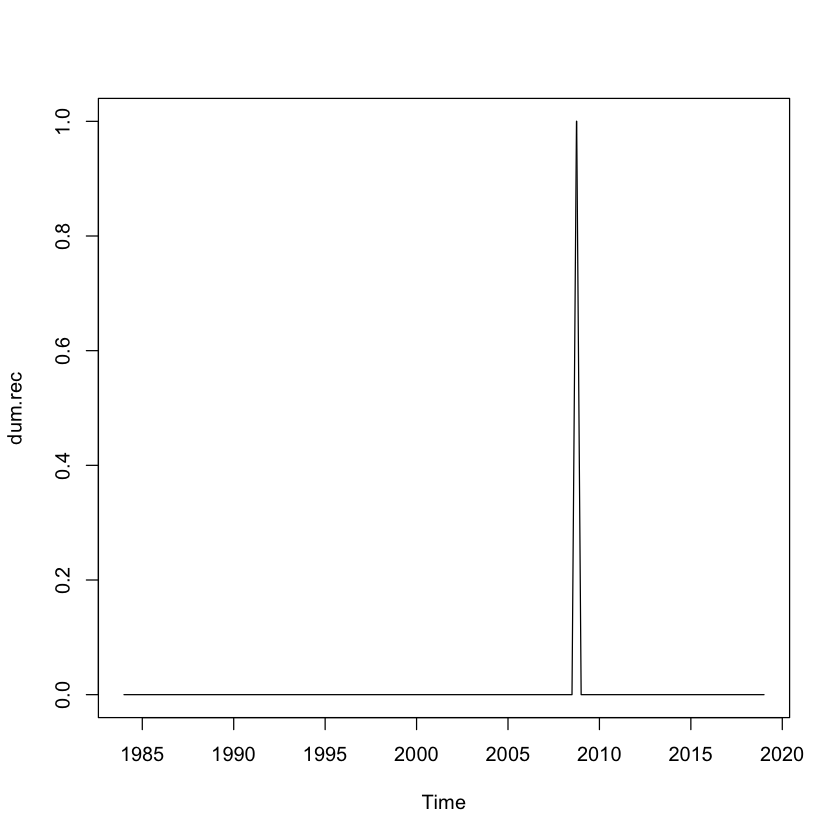

In [18]:
dum.rec = matrix(0,T,1)
dum.rec[100,1] = 1
dum.rec = ts(dum.rec,start=c(1984,1),freq=4)
ts.plot(dum.rec)

In [19]:
ar1.mod = dynlm(z2 ~ L(z2,1) + dum.rec) # now AR(1)+X model
ar1 = summary(ar1.mod)
ar1


Time series regression with "ts" data:
Start = 1984(2), End = 2019(1)

Call:
dynlm(formula = z2 ~ L(z2, 1) + dum.rec)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.8076 -0.8825  0.0768  0.9252  3.6103 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.56988    0.20679   7.591 4.41e-12 ***
L(z2, 1)      0.42404    0.06393   6.633 7.02e-10 ***
dum.rec     -13.43246    1.48018  -9.075 1.09e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.458 on 137 degrees of freedom
Multiple R-squared:  0.4466,	Adjusted R-squared:  0.4385 
F-statistic: 55.29 on 2 and 137 DF,  p-value: < 2.2e-16



	Jarque Bera Test

data:  ar1$res
X-squared = 11.754, df = 2, p-value = 0.002803


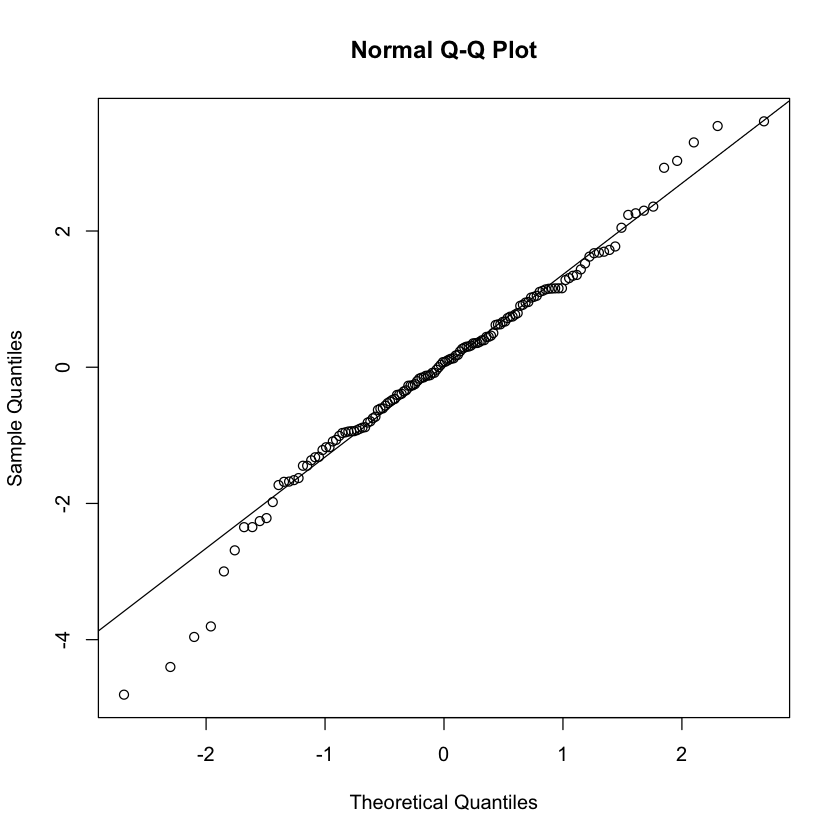

In [20]:
jarque.bera.test(ar1$res)
qqnorm(ar1$res)
qqline(ar1$res)